In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import pickle
from classification_utils import *
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
import os
import sys
sys.path.append(os.path.abspath('..'))
from plot_utils import *
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [2]:
RESULTS_DIR = '../data/classification_results/'
clf_names = [
    'RipperClassifier', 'DecisionTreeClassifier', 'RandomForestClassifier', 'AdaBoostClassifier', 'ExtremeGradientBoostingClassifier',
    'KNearestNeighborsClassifier', 'NearestCentroidClassifier', 'SupportVectorMachineClassifier',
    'NeuralNetworkClassifier', 'NaiveBayesMixedClassifier']
clf_names_abbr = [
     'RIPPER', 'DT', 'RF', 'AB', 'XGB', 'KNN', 'NC', 'SVM', 'NN', 'NB']

test_true_labels = pd.read_csv('../data/clf_y_test.csv')
test_data = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)

cv_train_scores = pd.DataFrame()
train_scores = pd.DataFrame()
test_scores = pd.DataFrame()
test_preds = {}
for clf in clf_names:
    if clf not in ['NaiveBayesMixedClassifier', 'TabNetClassifier']:
        clf_cv_train_scores = pd.read_csv(RESULTS_DIR+clf+'_train_cv_scores.csv', index_col=0)
        cv_train_scores = pd.concat([cv_train_scores, clf_cv_train_scores], axis=0)
    clf_train_scores = pd.read_csv(RESULTS_DIR+clf+'_train_scores.csv', index_col=0)
    train_scores = pd.concat([train_scores, clf_train_scores], axis=0)
    clf_test_scores = pd.read_csv(RESULTS_DIR+clf+'_test_scores.csv', index_col=0)
    test_scores = pd.concat([test_scores, clf_test_scores], axis=0)
    clf_test_preds = pd.read_csv(RESULTS_DIR+clf+'_preds.csv')
    test_preds[clf] = {}
    test_preds[clf]['labels'] = clf_test_preds['labels']
    if clf not in ['NearestCentroidClassifier']:
        test_preds[clf]['probs'] = clf_test_preds['probs']

Train scores comparison:

In [3]:
cv_train_scores[['std_test_score', 'mean_test_score']].style.background_gradient(cmap='Blues', axis=0)

,std_test_score,mean_test_score
RipperClassifier,0.002218,0.396244
DecisionTreeClassifier,0.004611,0.610243
RandomForestClassifier,0.004239,0.614493
AdaBoostClassifier,0.003758,0.581472
ExtremeGradientBoostingClassifier,0.005298,0.636308
KNearestNeighborsClassifier,0.003557,0.461970
NearestCentroidClassifier,0.003802,0.542331
SupportVectorMachineClassifier,0.001087,0.662482
NeuralNetworkClassifier,0.008270,0.542521


In [4]:
train_scores.style.background_gradient(cmap='Blues', axis=0)
train_scores[[
    'precision-Non-Fatal',
    'recall-Non-Fatal',
    'precision-Fatal',
    'recall-Fatal',
    'f1-score-macro avg',
    'accuracy',
    'auroc',
    'params'
    ]].style.background_gradient(cmap='Blues', axis=0).to_latex('./train.tex')

Test scores comparison:

In [5]:
test_scores[['precision-Non-Fatal', 'recall-Non-Fatal', 'precision-Fatal', 'recall-Fatal', 'f1-score-macro avg', 'accuracy', 'auroc', 'params']].style.background_gradient(cmap='Blues', axis=0)

,precision-Non-Fatal,recall-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-macro avg,accuracy,auroc,params
RipperClassifier,0.729376,0.953640,0.716244,0.248527,0.597789,0.727917,0.603319,"{'k': 2, 'prune_size': 0.5}"
DecisionTreeClassifier,0.840016,0.692526,0.524354,0.719884,0.682965,0.701284,0.787668,"{'class_weight': 'balanced', 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'random_state': 42}"
RandomForestClassifier,0.841808,0.706665,0.535416,0.717967,0.690868,0.710283,0.794481,"{'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'sqrt', 'max_samples': None, 'min_samples_leaf': 1, 'min_samples_split': 0.01, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 42}"
AdaBoostClassifier,0.804545,0.807073,0.587508,0.583588,0.695674,0.735530,0.786385,"{'algorithm': 'SAMME', 'estimator': DecisionTreeClassifier(class_weight='balanced', min_samples_split=0.01), 'learning_rate': 0.8, 'n_estimators': 200, 'random_state': 42}"
ExtremeGradientBoostingClassifier,0.852802,0.740123,0.569013,0.728686,0.715752,0.736462,0.818085,"{'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'eta': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'scale_pos_weight': 2.1236912156166814, 'subsample': 1}"
KNearestNeighborsClassifier,0.747327,0.759142,0.470692,0.454887,0.607921,0.661743,0.607015,"{'algorithm': 'brute', 'metric': 'minkowski', 'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}"
NearestCentroidClassifier,0.798693,0.629253,0.457179,0.663165,0.622578,0.640109,nan,{'metric': 'euclidean'}
SupportVectorMachineClassifier,0.846426,0.655458,0.505303,0.747427,0.670884,0.684899,0.776488,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"
NeuralNetworkClassifier,0.782182,0.873320,0.642487,0.483495,0.688504,0.748529,0.792479,"{'batch_size': 1024, 'epochs': 125, 'model__dropout': 0.5, 'model__final_activation_fun': 'sigmoid', 'model__hidden_layer_sizes': (256, 256, 256), 'model__output_bias': 0, 'optimizer': 'adamax', 'optimizer__learning_rate': 0.001}"
NaiveBayesMixedClassifier,0.749081,0.879103,0.593321,0.374601,0.634075,0.717600,0.733935,"MixedNB(alpha=0.5, var_smoothing=1e-09)"


Cross validation performance and standard deviation:

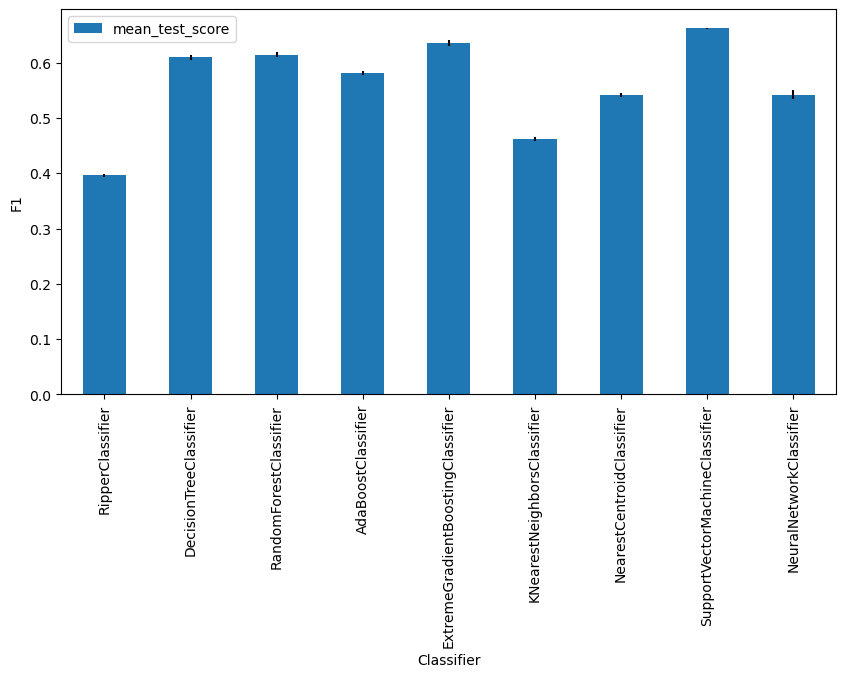

In [6]:
cv_train_scores.plot.bar(figsize=(10, 5), y='mean_test_score', yerr='std_test_score')
plt.xlabel('Classifier');
plt.ylabel('F1');

In [7]:
cv_train_scores['std_test_score'].describe()

count    9.000000
mean     0.004093
std      0.002007
min      0.001087
25%      0.003557
50%      0.003802
75%      0.004611
max      0.008270
Name: std_test_score, dtype: float64

In [8]:
cv_train_scores['std_test_score']

RipperClassifier                     0.002218
DecisionTreeClassifier               0.004611
RandomForestClassifier               0.004239
AdaBoostClassifier                   0.003758
ExtremeGradientBoostingClassifier    0.005298
KNearestNeighborsClassifier          0.003557
NearestCentroidClassifier            0.003802
SupportVectorMachineClassifier       0.001087
NeuralNetworkClassifier              0.008270
Name: std_test_score, dtype: float64

Training time comparison:

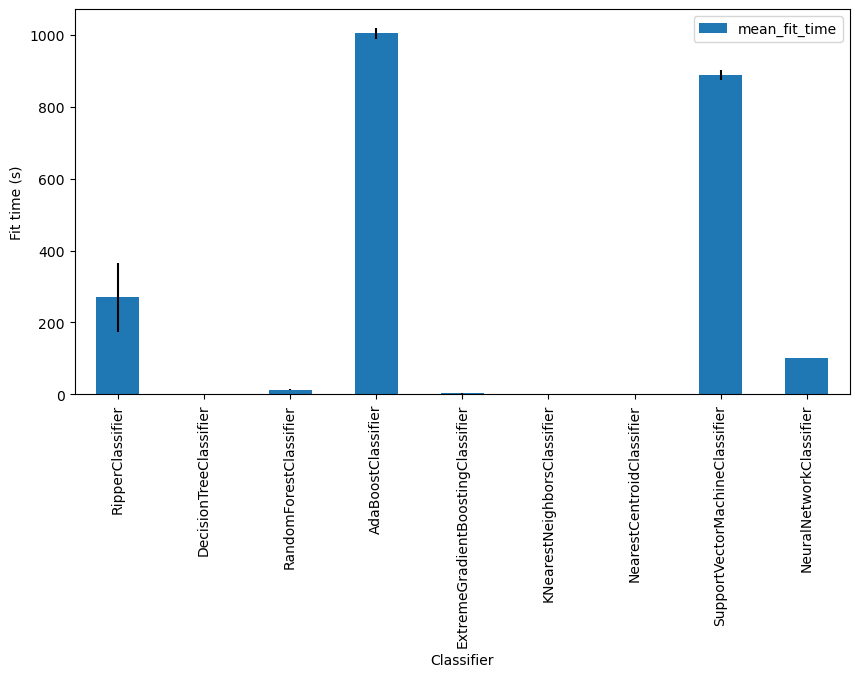

In [9]:
cv_train_scores.plot.bar(figsize=(10, 5), y='mean_fit_time', yerr='std_fit_time')
plt.xlabel('Classifier');
plt.ylabel('Fit time (s)');

Score time comparison:

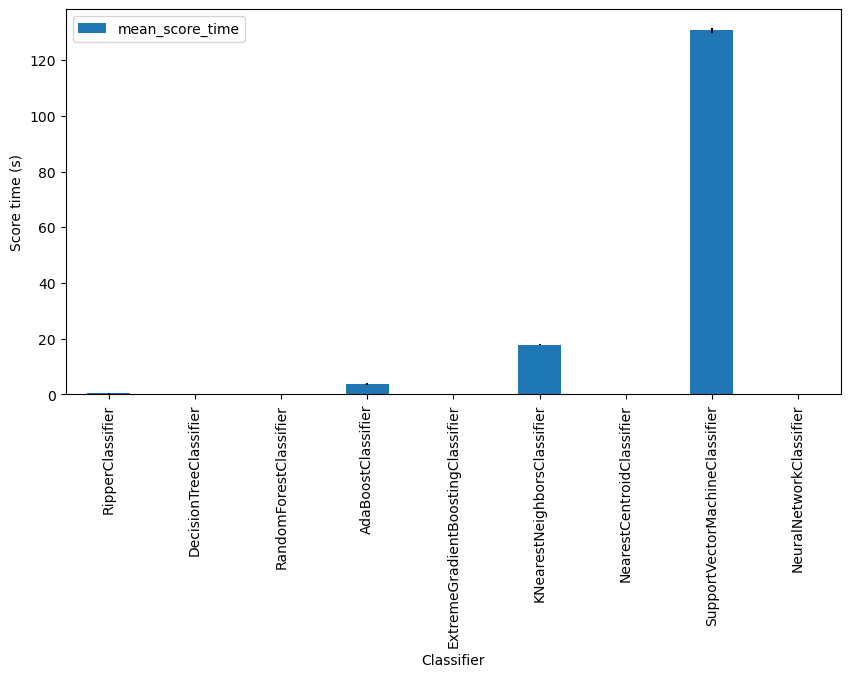

In [10]:
cv_train_scores.plot.bar(figsize=(10, 5), y='mean_score_time', yerr='std_score_time')
plt.xlabel('Classifier');
plt.ylabel('Score time (s)');

Train - Test scores comparison:

Text(0, 0.5, 'f1-score-macro avg')

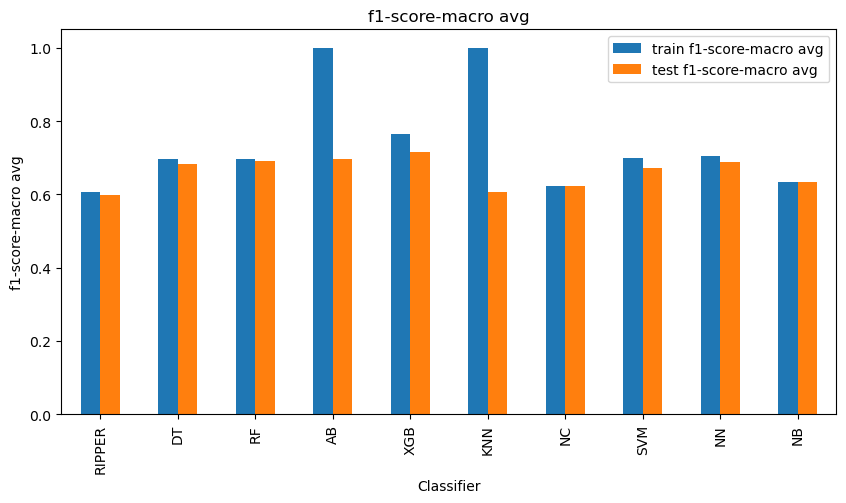

In [11]:
metric = 'f1-score-macro avg'
train_metric = train_scores[metric].reset_index().rename(columns={'index': 'clf', metric: 'train '+metric})
test_metric = test_scores[metric].reset_index().rename(columns={'index': 'clf', metric: 'test '+metric})
metrics = pd.merge(train_metric, test_metric, on='clf')
metrics.plot.bar(x='clf', figsize=(10, 5), title=metric)
plt.xticks(range(len(clf_names)), clf_names_abbr)
plt.xlabel('Classifier')
plt.ylabel(metric)

AUROC comparison:

Text(0.5, 1.0, 'Calibration curves')

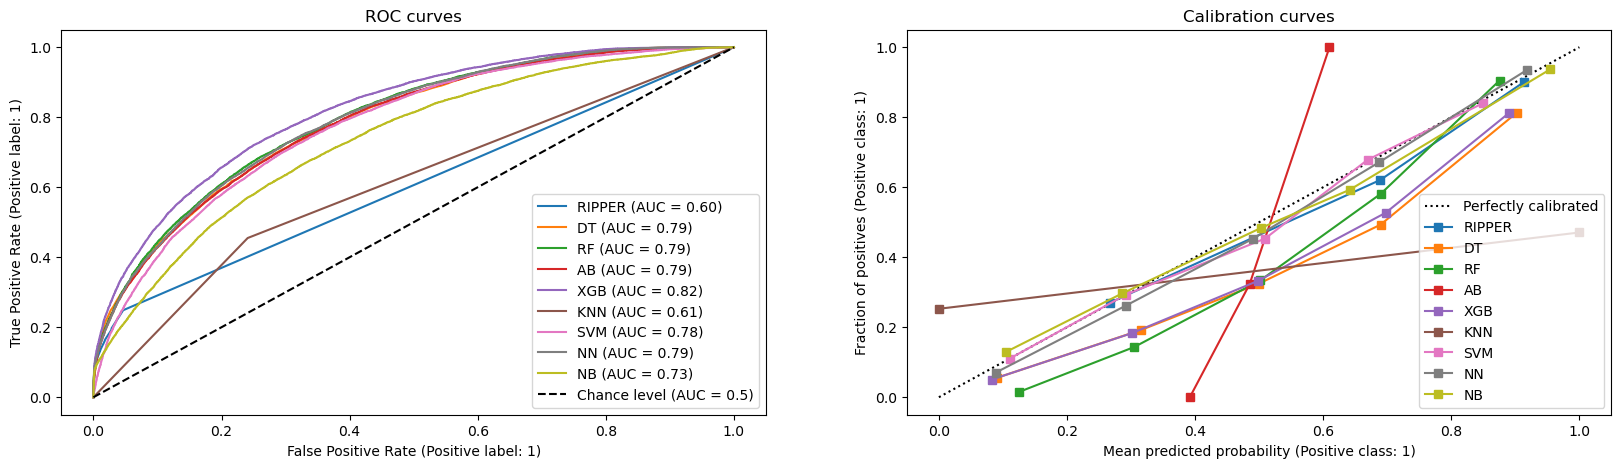

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

y_probs = [test_preds[clf]['probs'] for clf in clf_names if clf not in ['NearestCentroidClassifier']]
clf_names_prob = [clf for clf in clf_names if clf not in ['NearestCentroidClassifier']]
clf_names_abbr_prob = [clf for clf in clf_names_abbr if clf not in ['NC']]

plot_roc(test_true_labels['death'], y_probs, clf_names_abbr_prob, axs[0])
for i in range(len(clf_names_prob)):
    CalibrationDisplay.from_predictions(test_true_labels['death'], y_probs[i], name=clf_names_abbr_prob[i], ax=axs[1])
axs[1].set_title('Calibration curves')

Confusion matrix comparison:

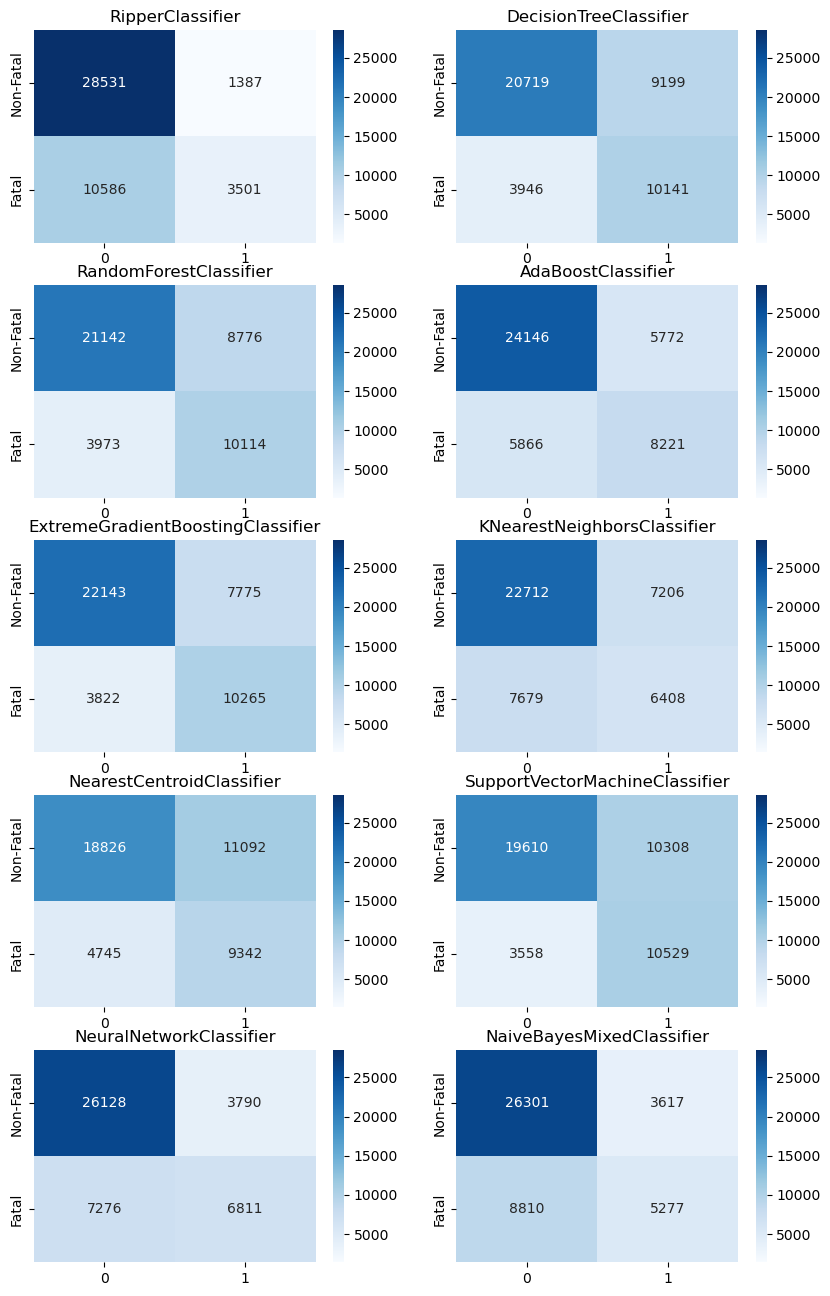

In [13]:
clf_names_mtx = clf_names
ncols = 2
nplots = len(clf_names_mtx)
nrows = int(nplots / ncols)
if nplots % ncols != 0:
    nrows += 1
f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,16), squeeze=False)
min = test_true_labels['death'].shape[0]
max = 0
# compute min and max to use same colorbar
cms = []
for clf in clf_names_mtx:
    cm = confusion_matrix(y_true=test_true_labels['death'], y_pred=test_preds[clf]['labels'], labels=[0,1])
    cms.append(cm)
    clf_min = cm.min()
    if clf_min < min:
        min = clf_min
    clf_max = cm.max()
    if clf_max > max:
        max = clf_max
# plot confusion matrix
for i, clf in enumerate(clf_names_mtx):
    sns.heatmap(cms[i], annot=True, fmt='g', ax=axs[int(i/ncols)][i%ncols], cmap='Blues', vmin=min, vmax=max, yticklabels=['Non-Fatal', 'Fatal'])
    axs[int(i/ncols)][i%ncols].set_title(clf);

Missclassification comparison:

In [14]:
sorted_clf_names = [
    'NearestCentroidClassifier', 'RipperClassifier', 'SupportVectorMachineClassifier',
    'NaiveBayesMixedClassifier',
    'NeuralNetworkClassifier', 'KNearestNeighborsClassifier', 'AdaBoostClassifier',
    'ExtremeGradientBoostingClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier'
]
clf_names_abbr = [
     'NC', 'RIPPER', 'SVM', 'NB', 'NN', 'KNN', 'AB', 'XGB', 'RF', 'DT']
labels = [test_preds[clf]['labels'] for clf in sorted_clf_names]
labels.append(test_true_labels['death'])
sankey_plot(
    labels=labels,
    labels_titles=clf_names_abbr+['True labels'],
    title='Classication comparison'
)

Rules comparison:

In [15]:
rule_based_clf_names = ['DecisionTreeClassifier', 'RandomForestClassifier']
for clf in rule_based_clf_names:
    print(clf)
    print("Incidents predicted as 'Fatal' with highest confidence")
    fatal_idx = test_preds[clf]['probs'][test_preds[clf]['labels']==1].sort_values(ascending=False).head(5).index.values
    display(test_data.iloc[fatal_idx])
    print("Incidents predicted as 'Non-Fatal' with highest confidence")
    nonfatal_idx = test_preds[clf]['probs'][test_preds[clf]['labels']==0].sort_values(ascending=True).head(5).index.values
    display(test_data.iloc[nonfatal_idx])

DecisionTreeClassifier
Incidents predicted as 'Fatal' with highest confidence


,date,date_original,state,address,county,city,address_type,state_house_district,state_senate_district,px_code,participant_age1,participant1_child,participant1_teen,participant1_adult,participant1_male,participant1_female,min_age,max_age,n_child,n_teen,n_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,notes,incident_characteristics1,incident_characteristics2,candidate_votes,total_votes,candidate_perc,population_state_2010,location_imp,latitude,longitude,x,y,state_code,congressional_district,age_range,avg_age,n_child_prop,n_teen_prop,n_males_prop,n_participants,day,day_x,day_y,day_of_week,day_of_week_x,day_of_week_y,month,month_x,month_y,year,days_from_first_incident,poverty_perc,democrat,gun_law_rank,aggression,accidental,defensive,suicide,road,house,school,business,illegal_holding,drug_alcohol,officers,organized,social_reasons,abduction
6973,2018-03-07,2018-03-07,SOUTH DAKOTA,308 Parker Dr,Pennington County,Box Elder,amenity,29.0,29.0,SD,20.0,False,False,True,True,False,20.0,20.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,NaN,"Shot - Dead (murder, accidental, suicide)",NaN,202446.0,335471.0,60.346796,814180,0.00001,44.1337,-103.069,174496.461931,4.894778e+06,41,0.0,0.0,20.0,0.0,0.0,1.0,1.0,7,0.988468,0.151428,2,0.974928,-0.222521,3,1.000000e+00,6.123234e-17,2018,1891,11.0,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
179311,2016-06-18,2016-06-18,UTAH,NaN,Cache County,Logan,amenity,4.0,25.0,UT,16.0,False,True,False,True,False,16.0,16.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,Teen cleaning loaded gun shot self in leg.,Shot - Wounded/Injured,Non-Aggression Incident,182925.0,277451.0,65.930561,2763885,0.00001,41.7292,-111.833,-568265.835763,4.700055e+06,44,1.0,0.0,16.0,0.0,1.0,1.0,1.0,18,-0.485302,-0.874347,5,-0.974928,-0.222521,6,1.224647e-16,-1.000000e+00,2016,1264,7.9,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
201128,2015-03-04,2015-03-04,IDAHO,205 8th Ave W,Owyhee County,Marsing,amenity,23.0,23.0,ID,15.0,False,True,False,True,False,15.0,15.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,Non-Shooting Incident,BB/Pellet/Replica gun,143580.0,220864.0,65.008331,1567582,0.00001,43.5436,-116.813,-939928.615524,4.977991e+06,12,1.0,0.0,15.0,0.0,1.0,1.0,1.0,4,0.724793,0.688967,2,0.974928,-0.222521,3,1.000000e+00,6.123234e-17,2015,792,11.7,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
81601,2017-08-06,2017-08-06,IDAHO,3300 block of Lancer Ave,Ada County,Boise,building,15.0,15.0,ID,19.0,False,False,True,True,False,19.0,19.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"shots fired following fight;\r\r\r\r\n43.634828, -116.341213 ;",Shots Fired - No Injuries,NaN,242252.0,355357.0,68.171444,1567582,0.00001,43.6348,-116.341,-899561.857100,4.979798e+06,12,1.0,0.0,19.0,0.0,0.0,1.0,1.0,6,0.937752,0.347305,6,-0.781831,0.623490,8,-8.660254e-01,-5.000000e-01,2017,1678,10.0,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13456,2016-09-14,2016-09-14,IDAHO,3300 block of East Deer Flat Road,Ada County,Kuna,building,22.0,22.0,ID,19.0,False,False,True,True,False,19.0,19.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,1.0,0.0,"result of argument via text, shot with 22 cal rifle",Shot - Wounded/Injured,NaN,242252.0,355357.0,68.171444,1567582,0.00001,43.5046,-116.372,-905188.011256,4.965860e+06,12,1.0,0.0,19.0,0.0,0.0,1.0,2.0,14,0.299363,-0.954139,2,0.974928,-0.222521,9,-1.000000e+00,-1.836970e-16,2016,1352,11.3,0.0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Incidents predicted as 'Non-Fatal' with highest confidence


,date,date_original,state,address,county,city,address_type,state_house_district,state_senate_district,px_code,participant_age1,participant1_child,participant1_teen,participant1_adult,participant1_male,participant1_female,min_age,max_age,n_child,n_teen,n_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,notes,incident_characteristics1,incident_characteristics2,candidate_votes,total_votes,candidate_perc,population_state_2010,location_imp,latitude,longitude,x,y,state_code,congressional_district,age_range,avg_age,n_child_prop,n_teen_prop,n_males_prop,n_participants,day,day_x,day_y,day_of_week,day_of_week_x,day_of_week_y,month,month_x,month_y,year,days_from_first_incident,poverty_perc,democrat,gun_law_rank,aggression,accidental,defensive,suicide,road,house,school,business,illegal_holding,drug_alcohol,officers,organized,social_reasons,abduction
91846,2018-03-28,2018-03-28,MARYLAND,5200 block of Cuthbert Ave,NaN,Baltimore,building,41.0,41.0,MD,31.0,False,False,True,True,False,31.0,31.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,Non-Shooting Incident,Drug involvement,202345.0,264710.0,76.440255,5773552,1.000000e-05,39.3463,-76.6803,2.431955e+06,4.600664e+06,20,7.0,0.0,31.0,0.0,0.0,1.0,1.0,28,-0.571268,0.820763,2,0.974928,-0.222521,3,1.000000,6.123234e-17,2018,1912,8.1,1.0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
38130,2017-04-22,2017-04-22,MASSACHUSETTS,Burke Ave and Worthen St,Berkshire County,Pittsfield,building,NaN,NaN,MA,30.0,False,False,True,True,False,30.0,30.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"wooded area, fired shots with unlicensed AK style rifle and 22 cal rifle",Shots Fired - No Injuries,ATF/LE Confiscation/Raid/Arrest,235803.0,349676.0,67.434711,6547629,1.000000e-05,42.4762,-73.2373,2.621889e+06,5.036626e+06,21,1.0,0.0,30.0,0.0,0.0,1.0,1.0,22,-0.968077,-0.250653,5,-0.974928,-0.222521,4,0.866025,-5.000000e-01,2017,1572,9.2,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
200003,2015-03-17,2015-03-17,CONNECTICUT,West Avenue,Western Connecticut Planning Region,Stamford,place,145.0,27.0,CT,23.0,False,False,True,True,False,23.0,23.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"overheard convo to sell gun, traffic stop near gas station, felon with loaded 38 cal Charter Arms police snub-nosed revolver",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,101401.0,198800.0,51.006539,3574097,1.000000e-05,41.0473,-73.5471,2.646963e+06,4.868676e+06,6,4.0,0.0,23.0,0.0,0.0,1.0,1.0,17,-0.299363,-0.954139,1,0.781831,0.623490,3,1.000000,6.123234e-17,2015,805,9.9,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
105846,2016-08-05,2016-08-05,SOUTH CAROLINA,NaN,Dillon County,Dillon,place,55.0,30.0,SC,41.0,False,False,True,True,False,41.0,41.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,176468.0,289463.0,60.963923,4625364,1.000000e-07,34.4107,-79.3602,2.317457e+06,3.987946e+06,40,7.0,0.0,41.0,0.0,0.0,1.0,1.0,5,0.848644,0.528964,4,-0.433884,-0.900969,8,-0.866025,-5.000000e-01,2016,1312,14.1,0.0,13,0,0,0,0,0,0,0,0,1,0,1,0,0,0
38932,2016-02-01,2016-02-01,IDAHO,NaN,Valley County,McCall,tourism,8.0,8.0,ID,45.0,False,False,True,True,False,45.0,45.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,NaN,Non-Shooting Incident,Possession of gun by felon or prohibited person,242252.0,355357.0,68.171444,1567582,1.000000e-05,44.9111,-116.0980,-8.494862e+05,5.117390e+06,12,1.0,0.0,45.0,0.0,0.0,1.0,1.0,1,0.201299,0.979530,0,0.000000,1.000000,2,0.866025,5.000000e-01,2016,1126,11.3,0.0,13,0,0,0,0,0,0,0,0,1,0,0,0,0,0


RandomForestClassifier
Incidents predicted as 'Fatal' with highest confidence


,date,date_original,state,address,county,city,address_type,state_house_district,state_senate_district,px_code,participant_age1,participant1_child,participant1_teen,participant1_adult,participant1_male,participant1_female,min_age,max_age,n_child,n_teen,n_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,notes,incident_characteristics1,incident_characteristics2,candidate_votes,total_votes,candidate_perc,population_state_2010,location_imp,latitude,longitude,x,y,state_code,congressional_district,age_range,avg_age,n_child_prop,n_teen_prop,n_males_prop,n_participants,day,day_x,day_y,day_of_week,day_of_week_x,day_of_week_y,month,month_x,month_y,year,days_from_first_incident,poverty_perc,democrat,gun_law_rank,aggression,accidental,defensive,suicide,road,house,school,business,illegal_holding,drug_alcohol,officers,organized,social_reasons,abduction
116000,2014-10-07,2014-10-07,ARKANSAS,4510 Thompson Road,Jefferson County,Pine Bluff,place,16.0,27.0,AR,68.0,False,False,True,True,False,64.0,68.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,husband and wife shot and killed; possible murder/suicide,"Shot - Dead (murder, accidental, suicide)",Suicide^,110789.0,206131.0,53.746889,2915918,1.000000e-07,34.1621,-92.0506,1.141124e+06,3.802027e+06,3,4.0,4.0,66.0,0.0,0.0,0.5,2.0,7,0.988468,0.151428,1,0.781831,0.62349,10,-0.866025,5.000000e-01,2014,644,16.8,0.0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0
32744,2016-09-27,2016-09-27,SOUTH CAROLINA,593 Roe Center Ct,Greenville County,Travelers Rest,amenity,17.0,6.0,SC,61.0,False,False,True,False,True,61.0,67.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,"Greenville Co, husband shot wife, then self, husband DIED 9/29","Shot - Dead (murder, accidental, suicide)",Suicide^,198648.0,295670.0,67.185714,4625364,1.000000e-05,34.9596,-82.4373,2.019260e+06,3.996498e+06,40,4.0,6.0,64.0,0.0,0.0,0.5,2.0,27,-0.724793,0.688967,1,0.781831,0.62349,9,-1.000000,-1.836970e-16,2016,1365,14.1,0.0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0
74573,2017-09-05,2017-09-05,FLORIDA,2419 SW 55th Avenue Rd,Marion County,NaN,leisure,22.0,8.0,FL,76.0,False,False,True,False,True,76.0,81.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,NaN,"Shot - Dead (murder, accidental, suicide)",Suicide^,231163.0,343362.0,67.323408,18801310,1.000000e-05,29.2118,-82.2124,2.144045e+06,3.351190e+06,9,2.0,5.0,78.0,0.0,0.0,0.5,2.0,5,0.848644,0.528964,1,0.781831,0.62349,9,-1.000000,-1.836970e-16,2017,1708,12.8,0.0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0
53870,2018-02-13,2018-02-13,KENTUCKY,414 Mount Carmel Road,Bourbon County,NaN,place,72.0,27.0,KY,45.0,False,False,True,False,True,45.0,50.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,"38.302198, -84.278626","Shot - Dead (murder, accidental, suicide)",Suicide^,154468.0,302888.0,50.998389,4339367,1.000000e-07,38.3050,-84.2960,1.788803e+06,4.343446e+06,17,6.0,5.0,48.0,0.0,0.0,0.5,2.0,13,0.485302,-0.874347,1,0.781831,0.62349,2,0.866025,5.000000e-01,2018,1869,14.4,0.0,13,0,0,0,1,0,0,0,0,0,0,0,0,0,0
139164,2015-09-07,2015-09-07,WEST VIRGINIA,Red Sulphur Turnpike,Mercer County,Athens,place,27.0,6.0,WV,48.0,False,False,True,False,True,48.0,55.0,0.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,0.0,"Wife killed by husband in murder-suicide, 12-gauge shotgun","Shot - Dead (murder, accidental, suicide)",Suicide^,77713.0,140401.0,55.350745,1852994,1.000000e-07,37.4223,-81.0162,2.097853e+06,4.297019e+06,48,3.0,7.0,52.0,0.0,0.0,0.5,2.0,7,0.988468,0.151428,0,0.000000,1.00000,9,-1.000000,-1.836970e-16,2015,979,16.6,0.0,12,0,0,0,1,0,0,0,0,0,0,0,0,0,0


Incidents predicted as 'Non-Fatal' with highest confidence


,date,date_original,state,address,county,city,address_type,state_house_district,state_senate_district,px_code,participant_age1,participant1_child,participant1_teen,participant1_adult,participant1_male,participant1_female,min_age,max_age,n_child,n_teen,n_adult,n_males,n_females,n_killed,n_injured,n_arrested,n_unharmed,notes,incident_characteristics1,incident_characteristics2,candidate_votes,total_votes,candidate_perc,population_state_2010,location_imp,latitude,longitude,x,y,state_code,congressional_district,age_range,avg_age,n_child_prop,n_teen_prop,n_males_prop,n_participants,day,day_x,day_y,day_of_week,day_of_week_x,day_of_week_y,month,month_x,month_y,year,days_from_first_incident,poverty_perc,democrat,gun_law_rank,aggression,accidental,defensive,suicide,road,house,school,business,illegal_holding,drug_alcohol,officers,organized,social_reasons,abduction
102643,2016-04-05,2016-04-05,MASSACHUSETTS,East Ashland and North Carey,Plymouth County,Brockton,building,NaN,NaN,MA,24.0,False,False,True,True,False,24.0,24.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"traffic stop, Glock 9mm",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,271019.0,396009.0,68.437586,6547629,0.00001,42.0961,-71.0092,2.820868e+06,5.057194e+06,21,8.0,0.0,24.0,0.0,0.0,1.0,1.0,5,0.848644,0.528964,1,0.781831,0.623490,4,8.660254e-01,-5.000000e-01,2016,1190,9.8,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
181895,2015-11-11,2015-11-11,MASSACHUSETTS,33 Regis Road,Suffolk County,Boston,building,NaN,NaN,MA,22.0,False,False,True,True,False,22.0,22.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"Mattapan, 2 guns incl hi point 9mm and Eastern Arms 32 cal",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,142133.0,176077.0,80.722070,6547629,0.00001,42.2703,-71.0958,2.806757e+06,5.074065e+06,21,7.0,0.0,22.0,0.0,0.0,1.0,1.0,11,0.790776,-0.612106,2,0.974928,-0.222521,11,-5.000000e-01,8.660254e-01,2015,1044,10.6,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
144688,2016-03-08,2016-03-08,MASSACHUSETTS,4907 Washington Street,Suffolk County,Boston,place,NaN,NaN,MA,23.0,False,False,True,True,False,23.0,23.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"West Roxbury, surveillance, computer bag with 3 guns incl 9mm hipoint, 38 cal S&W, 380 cal Jennings",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,271019.0,396009.0,68.437586,6547629,0.00001,42.2697,-71.1485,2.802416e+06,5.072444e+06,21,8.0,0.0,23.0,0.0,0.0,1.0,1.0,8,0.998717,-0.050649,1,0.781831,0.623490,3,1.000000e+00,6.123234e-17,2016,1162,9.8,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
194979,2016-03-08,2016-03-08,MASSACHUSETTS,27 Dunlap Street,Suffolk County,Boston,building,NaN,NaN,MA,25.0,False,False,True,True,False,25.0,25.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"Dorchester, Ruger 357",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,253354.0,309645.0,81.820795,6547629,0.00001,42.2929,-71.0734,2.807713e+06,5.077246e+06,21,7.0,0.0,25.0,0.0,0.0,1.0,1.0,8,0.998717,-0.050649,1,0.781831,0.623490,3,1.000000e+00,6.123234e-17,2016,1162,9.8,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
194831,2015-12-23,2015-12-23,MASSACHUSETTS,30 Winter Street,Suffolk County,Boston,building,NaN,NaN,MA,23.0,False,False,True,True,False,23.0,23.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,"followed by Lincoln St parking garage security after failed B&E, found with Hipoint 9mm",Non-Shooting Incident,ATF/LE Confiscation/Raid/Arrest,142133.0,176077.0,80.722070,6547629,0.00001,42.3560,-71.0618,2.806160e+06,5.084624e+06,21,7.0,0.0,23.0,0.0,0.0,1.0,1.0,23,-0.998717,-0.050649,2,0.974928,-0.222521,12,-2.449294e-16,1.000000e+00,2015,1086,10.6,1.0,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0
